In [2]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Define the directory for ASL images
image_dir = '/content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array

# Function to load images from a directory and preprocess them
def load_images(image_dir, target_size=(64, 64),number=1000):
    images = []
    labels = []

    for folder in os.listdir(image_dir):
      folder_path = os.path.join(image_dir, folder)
      if os.path.isdir(folder_path):
        file_count=0
        for file in os.listdir(folder_path):
          while file_count < number:
            if file.endswith('.jpg') or file.endswith('.png'):
              img_path = os.path.join(folder_path, file)
              img = Image.open(img_path).resize(target_size)
              img_array = img_to_array(img)
              images.append(img_array)
              labels.append(folder)  # Using folder name as label
              file_count = file_count + 1

    return np.array(images), np.array(labels)


def formate_predictions(predictions):
    for i,j in enumerate(predictions):
      guess=max(j)
      for k,l in enumerate(j):
        if l == guess:
          predictions[i][k] = 1
          continue
        predictions[i][k] = 0
      return predictions

# Load images
image_dir = '/content/drive/MyDrive/asl_alphabet_train/asl_alphabet_train'  # Update with the correct path
images, labels = load_images(image_dir,number=200)

# Split dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [16]:
# Model development
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


print("No saved model detected. Creating new model.")# Load and preprocess the dataset
# Base model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(np.unique(train_labels)), activation='softmax')(x)


# Final model
model = Model(inputs=base_model.input, outputs=predictions)
# Freeze "lower" layers
num_layers = len(model.layers) - 3
model.layers[num_layers].trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


No saved model detected. Creating new model.


In [17]:
# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [18]:
# Model Testing
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert to one-hot
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
if test_accuracy < 0.9:
  # Training the model
  model.fit(train_images,
              train_labels_one_hot,
              batch_size=32,
              epochs=2,
              validation_data=(test_images, test_labels_one_hot)
              )

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print("Test accuracy:", test_accuracy)

37/37 [==============================] - 4s 43ms/step - loss: 4.8613 - accuracy: 0.0371
Epoch 1/2
145/145 [==============================] - 40s 63ms/step - loss: 0.5376 - accuracy: 0.9390 - val_loss: 19.1421 - val_accuracy: 0.8155
Epoch 2/2
37/37 [==============================] - 1s 15ms/step - loss: 2.1690 - accuracy: 0.8621
Test accuracy: 0.8620689511299133


In [19]:
predictions = model.predict(test_images)

37/37 [==============================] - 2s 15ms/step


In [20]:
predictions=formate_predictions(predictions)

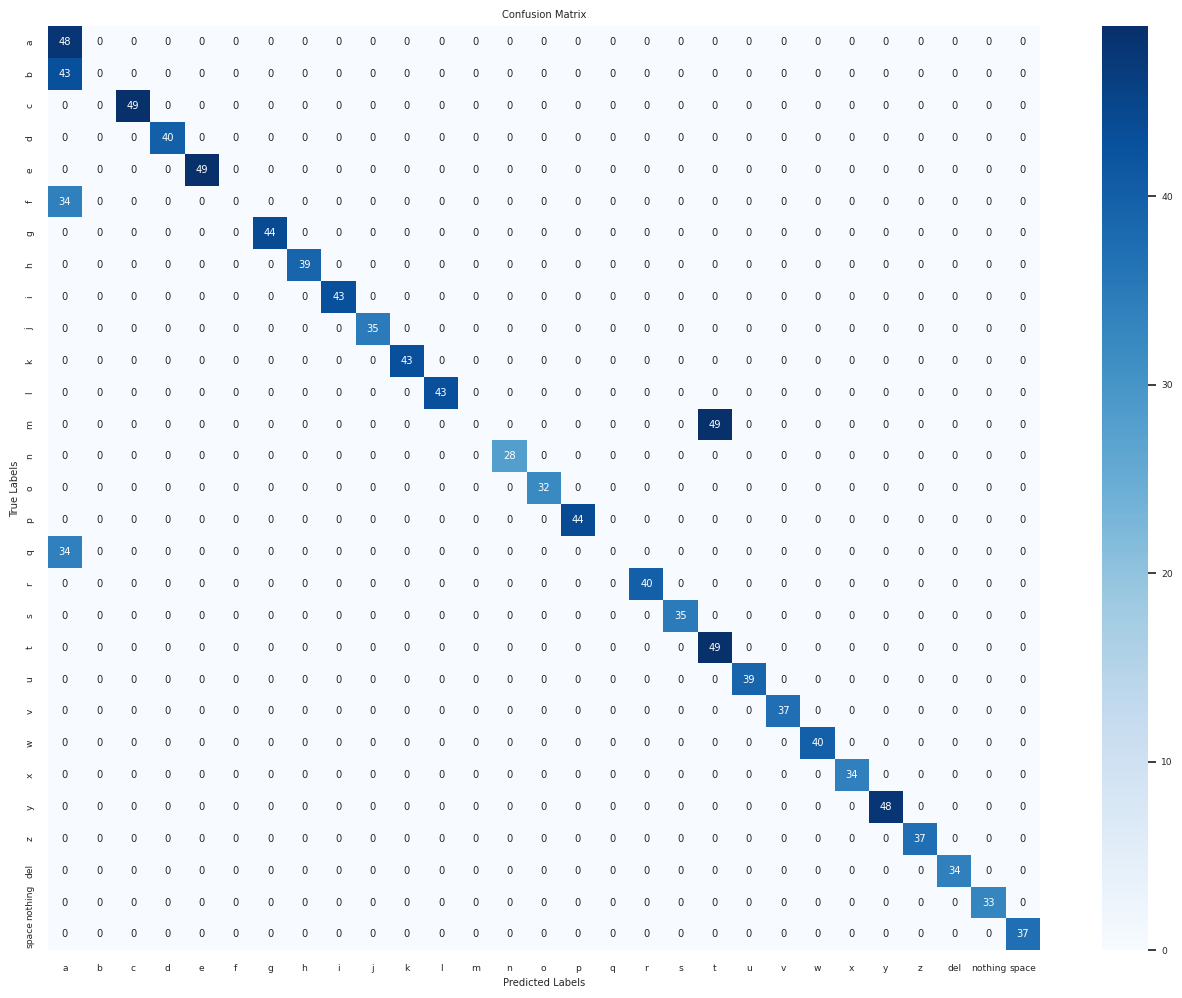

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(test_labels_one_hot,axis=1), np.argmax(predictions,axis=1))
alphabet_strings = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'del', 'nothing', 'space']
class_labels = alphabet_strings

plt.figure(figsize=(16, 12))
sns.set(font_scale=.6)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#GRADIO

In [ ]:
model = model.save("model.keras")

In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.5 MB/s e

In [ ]:
import gradio

gradio.Interface(greet, "text", "text",debug=True).launch(share=True)

NameError: name 'greet' is not defined

In [ ]:
# Gradio interface for model inference
import gradio as gr

def classify_image(inp):
    inp = inp.reshape((-1, 64, 64, 3))
    prediction = model.predict(inp).flatten()
    return {label: prediction[i] for i, label in enumerate(np.unique(labels))}

iface = gr.Interface(fn=classify_image, inputs=gr.inputs.Image(shape=(64, 64)), outputs=gr.outputs.Label(num_top_classes=3))
iface.launch()

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (/usr/local/lib/python3.10/dist-packages/typing_extensions.py)